In [332]:
from pathlib import Path
import numpy as np
import pandas as pd 
import json
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from plotly.offline import iplot

# enable plotly in VS Studio Code
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook" 

from workbench.wandb import wandb_model_DB, make_clickable, color_state, get_architecture_from_model_DB_run_id, get_model_DB_run_id_from_architecture, get_wandb_table_as_df


from workbench.utils.utils import convert_to_kb, create_kb_column

import wandb

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
%reload_ext autoreload
%autoreload

In [334]:
# Configure pandas to show all columns & rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get model_DB()

In [335]:
df  = wandb_model_DB()


In [336]:
df.columns

Index(['id', 'run_name', 'state', 'MACs', 'url', 'architecture', 'FLOPs',
       'alpha', 'classes', 'img_res', 'OPS_mltk', 'channels', 'macs_mltk',
       'variation', 'energy_mltk', 'total_params', 'OPS_INT8_mltk',
       'model_size_kb', 'peak_memory_b', 'macs_INT8_mltk', 'energy_INT8_mltk',
       'trainable_params', 'non_trainable_params', 'tflite_model_size_kb',
       'flash_model_size_b_mltk', 'n_unsupported_layers_mltk',
       'tflite_model_INT8_size_kb', 'flash_model_size_b__INT8_mltk',
       'RAM_runtime_memory_size_b_mltk', 'n_unsupported_layers_INT8_mltk',
       'RAM_runtime_memory_size_b_INT8_mltk', 'opt_RAM_mltk',
       'opt_RAM_INT8_mltk', 'tags', 'created_at', 'path', 'notes',
       'test_accuracy', 'inference_avg_us', 'stm32_inference_ms_INT8'],
      dtype='object')

In [337]:
df["peak_memory_kb"] = df["peak_memory_b"]/1024.0
df["flash_model_size_kb_INT8_mltk"] = df["flash_model_size_b__INT8_mltk"]/1024.0
df["RAM_runtime_memory_size_kb_INT8_mltk"] = df["RAM_runtime_memory_size_b_INT8_mltk"]/1024.0
df["alpha"] = df["alpha"].astype(str)
df["inference_GPU_ms"] = df["inference_avg_us"]/1000.
df.test_accuracy.fillna(0, inplace=True)
df['test_accuracy'] = df['test_accuracy'].replace("NaN", 0)
df["test_accuracy"] = df["test_accuracy"]*100
df["bytes_per_param"] = df["flash_model_size_b__INT8_mltk"] / df["total_params"]
df.style.format({'url': make_clickable}).applymap(color_state, subset=["state"])

,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param
0,340blyz9,mobilenetv2_0.35_96_c3_o2_keras,finished,10.657 M,https://wandb.ai/susbrock/model_DB/runs/340blyz9,mobilenetv2_0.35_96_c3_o2_keras,22.292 M,0.35,2,96,23843250.000000,3,10656688.000000,keras,0.011755,412770,23843250.000000,2075.156250,225840.000000,10656688.000000,0.011755,398690,14080,1545.226562,1582312.000000,0.000000,593.109375,607344.000000,970624.000000,0.000000,293716.000000,nan,nan,['basemodel'],2023-05-05T16:43:42,"['susbrock', 'model_DB', '340blyz9']",,86.226398,732.257000,126.559000,220.546875,593.109375,286.832031,0.732257,1.471386
1,ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,15.677 M,0.25,2,96,15676554.000000,3,7489664.000000,000,0.005933,221794,15676554.000000,1122.968750,55296.000000,7489664.000000,0.005933,216322,5472,834.453125,854480.000000,0.000000,293.781250,300832.000000,322200.000000,0.000000,101344.000000,nan,nan,['basemodel'],2023-05-04T14:46:26,"['susbrock', 'model_DB', 'ejrgwblg']",,85.387212,610.042000,66.360000,54.000000,293.781250,98.968750,0.610042,1.356358
2,t0dkz7ph,mobilenetv1vww_0.25_96_c3_o2_,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/t0dkz7ph,mobilenetv1vww_0.25_96_c3_o2_,15.677 M,0.25,2,96,15676554.000000,3,7489664.000000,,0.005933,221794,15676554.000000,1122.968750,55296.000000,7489664.000000,0.005933,216322,5472,834.453125,854480.000000,0.000000,293.781250,300832.000000,322200.000000,0.000000,101344.000000,nan,nan,[],2023-05-04T14:36:01,"['susbrock', 'model_DB', 't0dkz7ph']",None,0.000000,nan,nan,54.000000,293.781250,98.968750,nan,1.356358
3,qk7djxss,mobilenetv1_0.25_32_c3_o1000_l5ll1024pl512.MV1,finished,715.936 k,https://wandb.ai/susbrock/model_DB/runs/qk7djxss,mobilenetv1_0.25_32_c3_o1000_l5ll1024pl512.MV1,1.499 M,0.25,1000,32,1503144.000000,3,715936.000000,l5ll1024pl512.MV1,0.000580,331560,1503144.000000,1553.390625,6144.000000,715936.000000,0.000580,328520,3040,1282.324219,1313100.000000,0.000000,376.656250,385696.000000,50328.000000,0.000000,26080.000000,nan,nan,[],2023-04-28T19:33:02,"['susbrock', 'model_DB', 'qk7djxss']",None,0.000000,nan,nan,6.000000,376.656250,25.468750,nan,1.163277
4,1xwuaus5,mobilenetv1_0.25_224_c3_o1000_l5ll1024pl512.MV1,finished,22.793 M,https://wandb.ai/susbrock/model_DB/runs/1xwuaus5,mobilenetv1_0.25_224_c3_o1000_l5ll1024pl512.MV1,48.822 M,0.25,1000,224,48825768.000000,3,22792864.000000,l5ll1024pl512.MV1,0.047270,331560,48825768.000000,1553.390625,301056.000000,22792864.000000,0.047270,328520,3040,1282.324219,1313100.000000,0.000000,376.656250,385696.000000,1623176.000000,0.000000,419296.000000,nan,nan,[],2023-04-28T19:29:50,"['susbrock', 'model_DB', '1xwuaus5']",None,0.000000,nan,nan,294.000000,376.656250,409.468750,nan,1.163277
5,7rw4jibd,mobilenetv1_0.25_96_c3_o1000_l5ll1024pl512.MV1,finished,4.395 M,https://wandb.ai/susbrock/model_DB/runs/7rw4jibd,mobilenetv1_0.25_96_c3_o1000_l5ll1024pl512.MV1,9.386 M,0.25,1000,96,9390248.000000,3,4395424.000000,l5ll1024pl512.MV1,0.004402,331560,9390248.000000,1553.390625,55296.000000,4395424.000000,0.004402,328520,3040,1282.324219,1313100.000000,0.000000,376.656250,385696.000000,312472.000000,0.000000,91616.000000,nan,nan,[],2023-04-28T19:26:35,"['susbrock', 'model_DB', '7rw4jibd']",None,0.000000,nan,nan,54.000000,

In [338]:
#df.test_accuracy.value_counts()

## Cleanup "tags" column

In [339]:
type(df.tags.value_counts())
df.tags.value_counts()

[]              283
[basemodel]      14
[comparison]      5
[too big]         2
Name: tags, dtype: int64

In [340]:
tags =df["tags"]
tags_df = pd.DataFrame(tags.to_list())
#tags_df.fillna(0, inplace=True)
tags_df.head()

,0
0,basemodel
1,basemodel
2,None
3,None
4,None


In [341]:
df["tag"] = tags_df[0]
df.head()

,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param,tag
0,340blyz9,mobilenetv2_0.35_96_c3_o2_keras,finished,10.657 M,https://wandb.ai/susbrock/model_DB/runs/340blyz9,mobilenetv2_0.35_96_c3_o2_keras,22.292 M,0.35,2,96,23843250.0,3,10656688.0,keras,0.011755,412770,23843250.0,2075.156250,225840.0,10656688.0,0.011755,398690,14080,1545.226562,1582312.0,0.0,593.109375,607344.0,970624.0,0.0,293716.0,NaN,NaN,[basemodel],2023-05-05T16:43:42,"[susbrock, model_DB, 340blyz9]",,86.226398,732.257,126.559,220.546875,593.109375,286.832031,0.732257,1.471386,basemodel
1,ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,15.677 M,0.25,2,96,15676554.0,3,7489664.0,000,0.005933,221794,15676554.0,1122.968750,55296.0,7489664.0,0.005933,216322,5472,834.453125,854480.0,0.0,293.781250,300832.0,322200.0,0.0,101344.0,NaN,NaN,[basemodel],2023-05-04T14:46:26,"[susbrock, model_DB, ejrgwblg]",,85.387212,610.042,66.360,54.000000,293.781250,98.968750,0.610042,1.356358,basemodel
2,t0dkz7ph,mobilenetv1vww_0.25_96_c3_o2_,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/t0dkz7ph,mobilenetv1vww_0.25_96_c3_o2_,15.677 M,0.25,2,96,15676554.0,3,7489664.0,,0.005933,221794,15676554.0,1122.968750,55296.0,7489664.0,0.005933,216322,5472,834.453125,854480.0,0.0,293.781250,300832.0,322200.0,0.0,101344.0,NaN,NaN,[],2023-05-04T14:36:01,"[susbrock, model_DB, t0dkz7ph]",None,0.000000,NaN,NaN,54.000000,293.781250,98.968750,NaN,1.356358,None
3,qk7djxss,mobilenetv1_0.25_32_c3_o1000_l5ll1024pl512.MV1,finished,715.936 k,https://wandb.ai/susbrock/model_DB/runs/qk7djxss,mobilenetv1_0.25_32_c3_o1000_l5ll1024pl512.MV1,1.499 M,0.25,1000,32,1503144.0,3,715936.0,l5ll1024pl512.MV1,0.000580,331560,1503144.0,1553.390625,6144.0,715936.0,0.000580,328520,3040,1282.324219,1313100.0,0.0,376.656250,385696.0,50328.0,0.0,26080.0,NaN,NaN,[],2023-04-28T19:33:02,"[susbrock, model_DB, qk7djxss]",None,0.000000,NaN,NaN,6.000000,376.656250,25.468750,NaN,1.163277,None
4,1xwuaus5,mobilenetv1_0.25_224_c3_o1000_l5ll1024pl512.MV1,finished,22.793 M,https://wandb.ai/susbrock/model_DB/runs/1xwuaus5,mobilenetv1_0.25_224_c3_o1000_l5ll1024pl512.MV1,48.822 M,0.25,1000,224,48825768.0,3,22792864.0,l5ll1024pl512.MV1,0.047270,331560,48825768.0,1553.390625,301056.0,22792864.0,0.047270,328520,3040,1282.324219,1313100.0,0.0,376.656250,385696.0,1623176.0,0.0,419296.0,NaN,NaN,[],2023-04-28T19:29:50,"[susbrock, model_DB, 1xwuaus5]",None,0.000000,NaN,NaN,294.000000,376.656250,409.468750,NaN,1.163277,None


In [342]:
df.architecture.isna()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    304 non-null    object 
 1   run_name                              304 non-null    object 
 2   state                                 304 non-null    object 
 3   MACs                                  304 non-null    object 
 4   url                                   304 non-null    object 
 5   architecture                          304 non-null    object 
 6   FLOPs                                 304 non-null    object 
 7   alpha                                 304 non-null    object 
 8   classes                               304 non-null    int64  
 9   img_res                               304 non-null    int64  
 10  OPS_mltk                              302 non-null    float64
 11  channels           

In [396]:
max_macs = 60000000
max_flash = 250
max_ram = 256000 
df["fit"] = True

df.loc[ (df.tflite_model_INT8_size_kb >=max_flash) | (df.macs_mltk>=max_macs) | (df.RAM_runtime_memory_size_b_INT8_mltk >=max_ram), "fit"] = False
# df.loc[df.tflite_model_INT8_size_kb >=max_flash, "fit"] = False
# df.loc[df.macs_mltk >=max_macs, "fit"] = False
# df.loc[df.RAM_runtime_memory_size_b_INT8_mltk >=max_ram, "fit"] = False

In [397]:
df.head(5)

,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param,tag,fit
0,340blyz9,mobilenetv2_0.35_96_c3_o2_keras,finished,10.657 M,https://wandb.ai/susbrock/model_DB/runs/340blyz9,mobilenetv2_0.35_96_c3_o2_keras,22.292 M,0.35,2,96,23843250.0,3,10656688.0,keras,0.011755,412770,23843250.0,2075.156250,225840.0,10656688.0,0.011755,398690,14080,1545.226562,1582312.0,0.0,593.109375,607344.0,970624.0,0.0,293716.0,NaN,NaN,[basemodel],2023-05-05T16:43:42,"[susbrock, model_DB, 340blyz9]",,86.226398,732.257,126.559,220.546875,593.109375,286.832031,0.732257,1.471386,basemodel,False
1,ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,15.677 M,0.25,2,96,15676554.0,3,7489664.0,000,0.005933,221794,15676554.0,1122.968750,55296.0,7489664.0,0.005933,216322,5472,834.453125,854480.0,0.0,293.781250,300832.0,322200.0,0.0,101344.0,NaN,NaN,[basemodel],2023-05-04T14:46:26,"[susbrock, model_DB, ejrgwblg]",,85.387212,610.042,66.360,54.000000,293.781250,98.968750,0.610042,1.356358,basemodel,False
2,t0dkz7ph,mobilenetv1vww_0.25_96_c3_o2_,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/t0dkz7ph,mobilenetv1vww_0.25_96_c3_o2_,15.677 M,0.25,2,96,15676554.0,3,7489664.0,,0.005933,221794,15676554.0,1122.968750,55296.0,7489664.0,0.005933,216322,5472,834.453125,854480.0,0.0,293.781250,300832.0,322200.0,0.0,101344.0,NaN,NaN,[],2023-05-04T14:36:01,"[susbrock, model_DB, t0dkz7ph]",None,0.000000,NaN,NaN,54.000000,293.781250,98.968750,NaN,1.356358,None,False
3,qk7djxss,mobilenetv1_0.25_32_c3_o1000_l5ll1024pl512.MV1,finished,715.936 k,https://wandb.ai/susbrock/model_DB/runs/qk7djxss,mobilenetv1_0.25_32_c3_o1000_l5ll1024pl512.MV1,1.499 M,0.25,1000,32,1503144.0,3,715936.0,l5ll1024pl512.MV1,0.000580,331560,1503144.0,1553.390625,6144.0,715936.0,0.000580,328520,3040,1282.324219,1313100.0,0.0,376.656250,385696.0,50328.0,0.0,26080.0,NaN,NaN,[],2023-04-28T19:33:02,"[susbrock, model_DB, qk7djxss]",None,0.000000,NaN,NaN,6.000000,376.656250,25.468750,NaN,1.163277,None,False
4,1xwuaus5,mobilenetv1_0.25_224_c3_o1000_l5ll1024pl512.MV1,finished,22.793 M,https://wandb.ai/susbrock/model_DB/runs/1xwuaus5,mobilenetv1_0.25_224_c3_o1000_l5ll1024pl512.MV1,48.822 M,0.25,1000,224,48825768.0,3,22792864.0,l5ll1024pl512.MV1,0.047270,331560,48825768.0,1553.390625,301056.0,22792864.0,0.047270,328520,3040,1282.324219,1313100.0,0.0,376.656250,385696.0,1623176.0,0.0,419296.0,NaN,NaN,[],2023-04-28T19:29:50,"[susbrock, model_DB, 1xwuaus5]",None,0.000000,NaN,NaN,294.000000,376.656250,409.468750,NaN,1.163277,None,False


In [398]:
df.fit.value_counts()

True     194
False    110
Name: fit, dtype: int64

In [399]:
#df.test_accuracy.value_counts

In [400]:
df.columns

Index(['id', 'run_name', 'state', 'MACs', 'url', 'architecture', 'FLOPs',
       'alpha', 'classes', 'img_res', 'OPS_mltk', 'channels', 'macs_mltk',
       'variation', 'energy_mltk', 'total_params', 'OPS_INT8_mltk',
       'model_size_kb', 'peak_memory_b', 'macs_INT8_mltk', 'energy_INT8_mltk',
       'trainable_params', 'non_trainable_params', 'tflite_model_size_kb',
       'flash_model_size_b_mltk', 'n_unsupported_layers_mltk',
       'tflite_model_INT8_size_kb', 'flash_model_size_b__INT8_mltk',
       'RAM_runtime_memory_size_b_mltk', 'n_unsupported_layers_INT8_mltk',
       'RAM_runtime_memory_size_b_INT8_mltk', 'opt_RAM_mltk',
       'opt_RAM_INT8_mltk', 'tags', 'created_at', 'path', 'notes',
       'test_accuracy', 'inference_avg_us', 'stm32_inference_ms_INT8',
       'peak_memory_kb', 'flash_model_size_kb_INT8_mltk',
       'RAM_runtime_memory_size_kb_INT8_mltk', 'inference_GPU_ms',
       'bytes_per_param', 'tag', 'fit'],
      dtype='object')

In [401]:
# check for redundant models in the model_DB
df["architecture"].value_counts()

mobilenetv2_0.35_96_c3_o2_keras                        1
mobilenetv1_0.1_96_c3_o2_l1.MV1                        1
MobilenetV3small_1_224_c3_o2_keras                     1
mobilenetv1_0.1_96_c3_o2_l2.GAP                        1
mobilenetv1_0.2_96_c3_o2_l5.MV1                        1
mobilenetv1_0.2_96_c3_o2_l4.MV1                        1
mobilenetv1_0.2_96_c3_o2_l3.MV1                        1
mobilenetv1_0.2_96_c3_o2_l2.MV1                        1
mobilenetv1_0.2_96_c3_o2_l1.MV1                        1
mobilenetv1_0.1_96_c3_o2_l3.MV1                        1
mobilenetv1vww_0.25_96_c3_o2_000                       1
mobilenetv1_0.1_96_c3_o2_l4.MV1                        1
shufflenetv2tiny_0.1_96_c3_o2_f24l512                  1
shufflenetv2tiny_0.1_96_c3_o2_f24l256                  1
shufflenetv2tiny_0.1_96_c3_o2_f24l64                   1
shufflenetv2tiny_0.1_96_c3_o2_f16l1024                 1
shufflenetv2tiny_0.1_96_c3_o2_f16l512                  1
shufflenetv2tiny_0.1_96_c3_o2_f

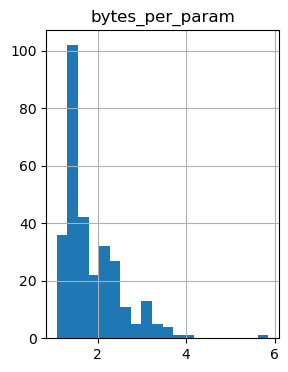

In [402]:
ax = df.hist(column=["bytes_per_param"],bins=20, figsize=(3, 4))

In [403]:
# shufflenetv2tiny_0.05_96_c3_o2_f24l128 

In [404]:
df["bytes_per_param"].argmax()

266

In [405]:
df["bytes_per_param"].max()

5.858667435823478

# Helper functions

In [406]:
# def get_model_DB_run_id_from_architecture(architecture):
#     df  = wandb_model_DB()

#     run_id = df.query(f"architecture=='{architecture}'")["id"].values[0]
#     return run_id

In [407]:
id = get_model_DB_run_id_from_architecture("efficientNetB0_0.05_96_c3_o2_keras")
id

'vtrfqgnv'

In [408]:
# get_architecture_from_model_DB_run_iddef (run_id):
#     # get model name from run_id
#     df  = wandb_model_DB()
#     model_name = df.query(f"id=='{run_id}'")['architecture'].values[0]
#     return model_name

In [409]:
myname = get_architecture_from_model_DB_run_id(id)
myname

'efficientNetB0_0.05_96_c3_o2_keras'

In [410]:
# training_csv_path = Path.cwd().joinpath("model_DB_visual_wake_words.csv")
# training_csv_path.is_file()
# # df = pd.read_csv(training_csv_path)
# # df

# Plotting functions

In [411]:
template = "plotly_white"#  ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]
bar_width = 0.35
width = 1200
height = 600

flash_memory_limit = 250
#flash_memory_limit
peak_memory_limit = 250
peak_memory_limit = 250


In [412]:
def get_model_family_df(model_family):

    
    model_list = df[["architecture"]].query(f"architecture.str.contains('{model_family}', na=False)").copy()
    model_list = model_list["architecture"].tolist()
    #print(model_list)
    family_df = df.query("architecture in @model_list").copy()
    family_df.sort_values(by="alpha", ascending=True, inplace=True)
    family_df["MACs_kB"]=create_kb_column(family_df, "MACs")
    print(f"Number of models: {len(family_df)}")
    
    return family_df

In [413]:
def memory_fig(df_long):

    peak_memory_limit = 87
    flash_memory_limit = flash_memory_limit
    fig = px.bar(df_long, x="architecture", color="size",
                y='value',
                labels={"architecture": "model architecture",
                            #"size": "size",
                            #"value": "kB"
                            },
                title="Peak memory, RAM size & flash size",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=600,
                template=template
                )
    fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
                annotation_position="top left")
    fig.add_hline(y=flash_memory_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{flash_memory_limit} KB flash memory", 
                annotation_position="top right")
    fig.show()
    return fig

In [414]:
def create_size_df_long(df):
    size_df = df[["architecture", 
             "peak_memory_kb", 
             "RAM_runtime_memory_size_kb_INT8_mltk",
             "flash_model_size_kb_INT8_mltk",
             "tflite_model_INT8_size_kb"
             ]].copy()
    df_long = pd.melt(size_df, id_vars=["architecture"], var_name= "size", value_name="value").sort_values(by=["architecture","size"])
    return df_long

In [415]:
def plot_accuracy_macs_by_model_family(model_family):
    family_df = get_model_family_df(model_family)
    macs_accuracy_fig = px.scatter(
    family_df,
    x = "macs_mltk",
    #x="MACs",
    #x="MACs_kb",
    y="test_accuracy",
    color="alpha",
    symbol="fit",
    symbol_sequence=["circle", "cross"],
    # get marker = "fit"
    hover_data=["run_name","alpha", "macs_mltk", "total_params", "peak_memory_kb"],
    #size="tflite_model_INT8_size_kb",
    #labels={"total_params": "parameters", "OPS_INT8_mltk": "FLOPs"},
    title=f"Accuracy vs. MACs - {model_family}",
    template=template
    )
    macs_accuracy_fig.update_layout(xaxis_range=[0, 15000000],
                                    yaxis_range= [0.75, 0.9],
                                    )
    return macs_accuracy_fig


# Get base models

In [416]:
basemodels = df.query(f"tag.str.contains('basemodel', na=False)").copy()
basemodels.sort_values("architecture", axis=0, inplace=True, key=lambda col: col.str.lower())
# max_accuracy = basemodels.test_accuracy.max()
# basemodels["leader"] = basemodels.test_accuracy = max_accuracy
basemodels

,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param,tag,fit
178,syyajz7h,efficientNetLiteB0_1_96_c3_o2_000,finished,70.516 M,https://wandb.ai/susbrock/model_DB/runs/syyajz7h,efficientNetLiteB0_1_96_c3_o2_000,143.333 M,1.0,2,96,147322620.0,3,70516192.0,000,0.057820,3415586,147322620.0,13799.734375,451680.0,70516192.0,0.057820,3373570,42016,13063.960938,13377496.0,0.0,3804.296875,3895600.0,1985256.0,0.0,630808.0,NaN,NaN,[basemodel],2023-03-12T21:40:01,"[susbrock, model_DB, syyajz7h]",,0.000000,4013.140,NaN,441.093750,3804.296875,616.023438,4.013140,1.140536,basemodel,False
126,yr1iql6l,effnet_0.3_96_c3_o2_000,finished,50.467 M,https://wandb.ai/susbrock/model_DB/runs/yr1iql6l,effnet_0.3_96_c3_o2_000,101.450 M,0.3,2,96,106094602.0,3,50466816.0,000,0.053131,186146,106094602.0,861.601562,589824.0,50466816.0,0.053131,183906,2240,726.199219,743628.0,0.0,223.492188,228856.0,2374944.0,0.0,605960.0,NaN,NaN,[basemodel],2023-03-23T19:52:48,"[susbrock, model_DB, yr1iql6l]",,85.140926,10033.100,643.613,576.000000,223.492188,591.757812,10.033100,1.229444,basemodel,False
278,zhmiturf,mnasnet_1_96_c3_o2_keras,finished,49.649 M,https://wandb.ai/susbrock/model_DB/runs/zhmiturf,mnasnet_1_96_c3_o2_keras,104.940 M,1.0,2,96,215129021.0,3,103265824.0,keras,0.086874,4269716,215277629.0,18749.273438,204352.0,103265824.0,0.087141,4232978,36738,16580.343750,16978272.0,0.0,5150.984375,5274608.0,1195500.0,0.0,569764.0,NaN,NaN,[basemodel],2023-02-19T08:39:21,"[susbrock, model_DB, zhmiturf]",,0.000000,19160.600,NaN,199.562500,5150.984375,556.410156,19.160600,1.235353,basemodel,False
299,i4nnlhl8,mobilenetv1_0.25_96_c3_o2_l5,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/i4nnlhl8,mobilenetv1_0.25_96_c3_o2_l5,15.674 M,0.25,2,96,15673996.0,3,7489664.0,l5,0.005974,221794,15784596.0,1123.593750,55296.0,7489664.0,0.006173,216322,5472,834.507812,854536.0,0.0,294.171875,301232.0,322644.0,0.0,101956.0,NaN,NaN,[basemodel],2023-02-05T20:59:40,"[susbrock, model_DB, i4nnlhl8]",,84.985864,1549.330,NaN,54.000000,294.171875,99.566406,1.549330,1.358161,basemodel,False
218,l679i489,mobilenetv1vvw_0.25_96_c3_o2_vvw,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/l679i489,mobilenetv1vvw_0.25_96_c3_o2_vvw,15.677 M,0.25,2,96,15676554.0,3,7489664.0,vvw,0.005933,221794,15787154.0,1121.812500,55296.0,7489664.0,0.006132,216322,5472,834.285156,854308.0,0.0,294.046875,301104.0,322200.0,0.0,101512.0,NaN,NaN,[basemodel],2023-03-05T17:09:22,"[susbrock, model_DB, l679i489]",,85.169643,502.384,66.360,54.000000,294.046875,99.132812,0.502384,1.357584,basemodel,False
1,ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,15.677 M,0.25,2,96,15676554.0,3,7489664.0,000,0.005933,221794,15676554.0,1122.968750,55296.0,7489664.0,0.005933,216322,5472,834.453125,854480.0,0.0,293.781250,300832.0,322200.0,0.0,101344.0,NaN,NaN,[basemodel],2023-05-04T14:46:26,"[susbrock, model_DB, ejrgwblg]",,85.387212,610.042,66.360,54.000000,293.781250,98.968750,0.610042,1.356358,basemodel,False
13,0695los0,mobilenetv2_0.1_96_c3_o2_keras,finished,4.664 M,https://wandb.ai/susbrock/model_DB/runs/0695los0,mobilenetv2_0.1_96_c3_o2_keras,10.056 M,0.1,2,96,11388762.0,3,4664128.0,keras,0.008760,95874,11388762.0,838.156250,225840.0,4664128.0,0.008760,88642,7232,357.246094,365820.0,0.0,213.882

In [417]:
basemodels.architecture.to_list()

['efficientNetLiteB0_1_96_c3_o2_000',
 'effnet_0.3_96_c3_o2_000',
 'mnasnet_1_96_c3_o2_keras',
 'mobilenetv1_0.25_96_c3_o2_l5',
 'mobilenetv1vvw_0.25_96_c3_o2_vvw',
 'mobilenetv1vww_0.25_96_c3_o2_000',
 'mobilenetv2_0.1_96_c3_o2_keras',
 'mobilenetv2_0.2_96_c3_o2_t6l1024.MV1',
 'mobilenetv2_0.35_96_c3_o2_keras',
 'MobilenetV3small_0.05_96_c3_o2_keras',
 'MobilenetV3small_0.1_96_c3_o2_keras',
 'shufflenetv1_0.35_96_c3_o2_g1',
 'shufflenetv1_0.35_96_c3_o2_g3',
 'shufflenetv2_0.5_96_c3_o2_000']

## Cleanup Displayed Architectures

In [418]:
remove_models = ["mobilenetv1vvw_0.25_96_c3_o2_vvw", "mobilenetv1_0.25_96_c3_o2_l5", "MobilenetV3small_0.05_96_c3_o2_keras", "mobilenetv2_0.2_96_c3_o2_t6l1024.MV1", "mobilenetv2_0.1_96_c3_o2_keras"]

basemodels = basemodels[basemodels.architecture.isin(remove_models) == False]
basemodels


,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param,tag,fit
178,syyajz7h,efficientNetLiteB0_1_96_c3_o2_000,finished,70.516 M,https://wandb.ai/susbrock/model_DB/runs/syyajz7h,efficientNetLiteB0_1_96_c3_o2_000,143.333 M,1.0,2,96,147322620.0,3,70516192.0,000,0.057820,3415586,147322620.0,13799.734375,451680.0,70516192.0,0.057820,3373570,42016,13063.960938,13377496.0,0.0,3804.296875,3895600.0,1985256.0,0.0,630808.0,NaN,NaN,[basemodel],2023-03-12T21:40:01,"[susbrock, model_DB, syyajz7h]",,0.000000,4013.140,NaN,441.093750,3804.296875,616.023438,4.013140,1.140536,basemodel,False
126,yr1iql6l,effnet_0.3_96_c3_o2_000,finished,50.467 M,https://wandb.ai/susbrock/model_DB/runs/yr1iql6l,effnet_0.3_96_c3_o2_000,101.450 M,0.3,2,96,106094602.0,3,50466816.0,000,0.053131,186146,106094602.0,861.601562,589824.0,50466816.0,0.053131,183906,2240,726.199219,743628.0,0.0,223.492188,228856.0,2374944.0,0.0,605960.0,NaN,NaN,[basemodel],2023-03-23T19:52:48,"[susbrock, model_DB, yr1iql6l]",,85.140926,10033.100,643.613,576.000000,223.492188,591.757812,10.033100,1.229444,basemodel,False
278,zhmiturf,mnasnet_1_96_c3_o2_keras,finished,49.649 M,https://wandb.ai/susbrock/model_DB/runs/zhmiturf,mnasnet_1_96_c3_o2_keras,104.940 M,1.0,2,96,215129021.0,3,103265824.0,keras,0.086874,4269716,215277629.0,18749.273438,204352.0,103265824.0,0.087141,4232978,36738,16580.343750,16978272.0,0.0,5150.984375,5274608.0,1195500.0,0.0,569764.0,NaN,NaN,[basemodel],2023-02-19T08:39:21,"[susbrock, model_DB, zhmiturf]",,0.000000,19160.600,NaN,199.562500,5150.984375,556.410156,19.160600,1.235353,basemodel,False
1,ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,finished,7.490 M,https://wandb.ai/susbrock/model_DB/runs/ejrgwblg,mobilenetv1vww_0.25_96_c3_o2_000,15.677 M,0.25,2,96,15676554.0,3,7489664.0,000,0.005933,221794,15676554.0,1122.968750,55296.0,7489664.0,0.005933,216322,5472,834.453125,854480.0,0.0,293.781250,300832.0,322200.0,0.0,101344.0,NaN,NaN,[basemodel],2023-05-04T14:46:26,"[susbrock, model_DB, ejrgwblg]",,85.387212,610.042,66.360,54.000000,293.781250,98.968750,0.610042,1.356358,basemodel,False
0,340blyz9,mobilenetv2_0.35_96_c3_o2_keras,finished,10.657 M,https://wandb.ai/susbrock/model_DB/runs/340blyz9,mobilenetv2_0.35_96_c3_o2_keras,22.292 M,0.35,2,96,23843250.0,3,10656688.0,keras,0.011755,412770,23843250.0,2075.156250,225840.0,10656688.0,0.011755,398690,14080,1545.226562,1582312.0,0.0,593.109375,607344.0,970624.0,0.0,293716.0,NaN,NaN,[basemodel],2023-05-05T16:43:42,"[susbrock, model_DB, 340blyz9]",,86.226398,732.257,126.559,220.546875,593.109375,286.832031,0.732257,1.471386,basemodel,False
261,gmoxau9c,MobilenetV3small_0.1_96_c3_o2_keras,finished,2.096 M,https://wandb.ai/susbrock/model_DB/runs/gmoxau9c,MobilenetV3small_0.1_96_c3_o2_keras,4.492 M,0.1,2,96,4873292.0,3,2096432.0,keras,0.004603,146714,4983892.0,1233.375000,75280.0,2096432.0,0.004802,144282,2432,601.660156,616100.0,0.0,269.265625,275728.0,338668.0,0.0,113628.0,NaN,NaN,[basemodel],2023-02-25T08:52:13,"[susbrock, model_DB, gmoxau9c]",,83.690596,1308.340,45.812,73.515625,269.265625,110.964844,1.308340,1.879357,basemodel,False
173,9lm0zws5,shufflenetv1_0.35_96_c3_o2_g1,finished,4.619 M,https://wandb.ai/susbrock/model_DB/runs/9lm0zws5,shufflenetv1_0.35_96_c3_o2_g1,9.922 M,0.35,2,96,9817285.0,3,4618968.0,g1,0.004159,129884,9817285.0,1147.101562,82944.0,4618968.0,0.004159,124784,5100,518.523438

In [419]:
def plot_model_parameters(df, title=""):
    fig = px.bar(df, 
                x="architecture", 
                color= "architecture",  # "leader"
                y='total_params',
                labels={"architecture": "Model Architectures",
                        "total_params" : "Parameters",
                            },
                #text_auto=".2s",
                title=f"Total Parameters {title}",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )

#     fig.update_traces(width=bar_width)
#     fig.add_annotation(x=2, y=5,
#             text="Text annotation with arrow",
#             showarrow=True,
#             arrowhead=1)
#     fig.add_annotation(x=4, y=4,
#             text="Text annotation without arrow",
#             showarrow=False,
#             yshift=0)
    #fig.show()
    fig.update_traces(width=bar_width)
    fig.update_layout(width=width, height=height)
    return fig

plot_model_parameters(basemodels, title=" - Base Models")

In [420]:
def plot_model_size(df, title=""):
    flash_memory_limit = 250
    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='tflite_model_INT8_size_kb',
                labels={"architecture": "Model Architectures",
                        "tflite_model_INT8_size_kb": "KB",

                            },
                #text='tflite_model_INT8_size_kb',
                #pattern_shape="fit",
                title=f"Model Size in KB {title}",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=700,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    fig.add_hline(y=flash_memory_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{flash_memory_limit} KB Flash Memory", 
                annotation_position="top right")
    fig.update_traces(width=bar_width)
    fig.update_layout(width=width, height=height)
    return fig

plot_model_size(basemodels, title=" - Base Models")

In [421]:
def plot_model_MACs(df, title=""):
    MACs_limit = 60000000
    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='macs_mltk',
                labels={"architecture": "Model architectures",
                        "macs_mltk": "MACs",
                            #"value": "kB"
                            },
                title=f"MACs {title}",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    fig.add_hline(y=MACs_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"60M MACs", 
                annotation_position="top right")
    fig.update_traces(width=bar_width)
    #fig.update_layout(margin=dict(b=300))
    #fig.update_xaxes(automargin=False)
    fig.update_layout(width=width, height=height)
    #fig.show()
    return fig

plot_model_MACs(basemodels, title=" - base models")

In [422]:



def plot_model_RAM(df, title=""):

    RAM_limit = 256
    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='RAM_runtime_memory_size_kb_INT8_mltk',
                labels={"architecture": "Model Architectures",
                        "RAM_runtime_memory_size_kb_INT8_mltk": "KB",
                            #"value": "kB"
                            },
                title=f"RAM in KB {title}",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    fig.add_hline(y=RAM_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{RAM_limit} KB RAM", 
                annotation_position="top right")
    fig.update_traces(width=bar_width)
    fig.update_traces(textfont_size=14, textangle=90, textposition="inside", cliponaxis=False)
    fig.update_layout(width=width, height=height)
    #fig.show()
    return fig

plot_model_RAM(basemodels, title=" - Base Models")

In [423]:


def plot_model_peak_memory(df, title=""):
    #peak_memory_limit = peak_memory_limit
    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='peak_memory_kb',
                labels={"architecture": "Model Architectures",
                        "peak_memory_kb": "KB",
                            #"value": "kB"
                            },
                title=f"Peak Memory in Kilobytes {title}",
                barmode='group',
                text_auto=".1f",
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{peak_memory_limit} KB Peak Memory", 
                annotation_position="top right")
    fig.update_traces(textfont_size=14, textangle=90, textposition="inside", cliponaxis=False)
    fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide') # 
    fig.update_traces(width=bar_width)
    fig.update_layout(width=width, height=height)
    #fig.show()
    return fig

plot_model_peak_memory(basemodels, title=" - Base Models")

In [424]:
def plot_model_accuracy(df, title=""):
    accuracy_limit = 80

    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='test_accuracy',
                labels={"architecture": "Model Architecture",
                        "test_accuracy": "Test Accuracy in %",
                            #"value": "kB"
                            },
                title=f"Test Accuracy in TensorFlow {title}",
                text_auto=".1f",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    fig.add_hline(y=accuracy_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{accuracy_limit} accuracy %", 
                annotation_position="top right")
    fig.update_traces(width=bar_width)
    fig.update_traces(textfont_size=14, textangle=90, textposition="inside", cliponaxis=False)
    fig.update_layout(yaxis_range= [81, 87])
    #fig.show()
    return fig

plot_model_accuracy(basemodels, title=" - base models")

In [425]:
def plot_model_latency_cpu(df, title=""):
    accuracy_limit = 0.80

    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='inference_GPU_ms',
                labels={"architecture": "model architecture",
                        "inference_GPU_ms": "ms",
                            #"value": "kB"
                            },
                title=f"average inference time on GPU in ms {title}",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    # fig.add_hline(y=accuracy_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{accuracy_limit} accuracy %", 
    #             annotation_position="top right")
    fig.update_traces(width=bar_width)
    # fig.update_layout(yaxis_range= [0.75, 0.9])
    #fig.show()
    return fig

plot_model_latency_cpu(basemodels, title=" - base models")

In [426]:
def plot_model_latency_mcu(df, title=""):
    accuracy_limit = 0.80

    fig = px.bar(df, 
                x="architecture", 
                color="architecture",
                y='stm32_inference_ms_INT8',
                labels={"architecture": "Model Architecture",
                        "stm32_inference_ms_INT8": "ms",
                            #"value": "kB"
                            },
                title=f"Average Inference Time on MCU in Milli Seconds {title}",
                barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    # fig.add_hline(y=accuracy_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{accuracy_limit} accuracy %", 
    #             annotation_position="top right")
    fig.update_traces(width=bar_width)
    # fig.update_layout(yaxis_range= [0.75, 0.9])
    #fig.show()
    return fig

plot_model_latency_mcu(basemodels, title=" - Base Models")

In [427]:
# basemodel_fig = go.Figure(data=[go.Bar(
#                                         name=
# )])

In [447]:
# fig = go.Figure(data=go.Scatterpolar(
#   r=[1, 5, 2, 2, 3],
#   theta=['processing cost','mechanical properties','chemical stability', 'thermal stability',
#            'device integration'],
#   fill='toself'
# ))

# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True
#     ),
#   ),
#   showlegend=False
# )

# fig.show()

In [429]:
# fig = go.Figure()

# fig.add_trace(go.Scatterpolar)

## Radar Charts

In [430]:
basemodels_radar = basemodels[["architecture", "test_accuracy",  "peak_memory_kb", "tflite_model_INT8_size_kb", "macs_mltk", "total_params", "stm32_inference_ms_INT8"]]
basemodels_radar.set_index("architecture", inplace=True)
basemodels_radar.fillna(0, inplace=True)
basemodels_radar

C:\Users\Susanne\AppData\Local\Temp\ipykernel_21320\2325692364.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,test_accuracy,peak_memory_kb,tflite_model_INT8_size_kb,macs_mltk,total_params,stm32_inference_ms_INT8
architecture,,,,,,
efficientNetLiteB0_1_96_c3_o2_000,0.000000,441.093750,3804.296875,70516192.0,3415586,0.000
effnet_0.3_96_c3_o2_000,85.140926,576.000000,223.492188,50466816.0,186146,643.613
mnasnet_1_96_c3_o2_keras,0.000000,199.562500,5150.984375,103265824.0,4269716,0.000
mobilenetv1vww_0.25_96_c3_o2_000,85.387212,54.000000,293.781250,7489664.0,221794,66.360
mobilenetv2_0.35_96_c3_o2_keras,86.226398,220.546875,593.109375,10656688.0,412770,126.559
MobilenetV3small_0.1_96_c3_o2_keras,83.690596,73.515625,269.265625,2096432.0,146714,45.812
shufflenetv1_0.35_96_c3_o2_g1,83.847135,81.000000,246.546875,4618968.0,129884,90.196
shufflenetv1_0.35_96_c3_o2_g3,84.210527,81.000000,283.148438,10084848.0,134798,137.703
shufflenetv2_0.5_96_c3_o2_000,85.835463,78.773438,1143.648438,19378760.0,944578,0.000


In [448]:
basemodels_radar_norm = pd.DataFrame()
basemodels_radar_norm["test_accuracy"] = basemodels_radar["test_accuracy"].copy()
basemodels_radar_norm["peak_memory_norm"] = basemodels_radar["peak_memory_kb"]/250 * 100
basemodels_radar_norm["model_size_norm"] = basemodels_radar["tflite_model_INT8_size_kb"]/250 * 100
basemodels_radar_norm["total_params_norm"] = basemodels_radar["total_params"]/(1024 *2.5) 
basemodels_radar_norm["inference_time_norm"] = basemodels_radar["stm32_inference_ms_INT8"] # /10
basemodels_radar_norm





,test_accuracy,peak_memory_norm,model_size_norm,total_params_norm,inference_time_norm
architecture,,,,,
efficientNetLiteB0_1_96_c3_o2_000,0.000000,176.437500,1521.718750,1334.213281,0.000
effnet_0.3_96_c3_o2_000,85.140926,230.400000,89.396875,72.713281,643.613
mnasnet_1_96_c3_o2_keras,0.000000,79.825000,2060.393750,1667.857812,0.000
mobilenetv1vww_0.25_96_c3_o2_000,85.387212,21.600000,117.512500,86.638281,66.360
mobilenetv2_0.35_96_c3_o2_keras,86.226398,88.218750,237.243750,161.238281,126.559
MobilenetV3small_0.1_96_c3_o2_keras,83.690596,29.406250,107.706250,57.310156,45.812
shufflenetv1_0.35_96_c3_o2_g1,83.847135,32.400000,98.618750,50.735937,90.196
shufflenetv1_0.35_96_c3_o2_g3,84.210527,32.400000,113.259375,52.655469,137.703
shufflenetv2_0.5_96_c3_o2_000,85.835463,31.509375,457.459375,368.975781,0.000


In [432]:
categories = basemodels_radar_norm.columns
fig = go.Figure()

for g in basemodels_radar_norm.index:
    fig.add_trace(go.Scatterpolar(
        r = basemodels_radar_norm.loc[g].values,
        theta = categories,
        fill = 'toself',
        name = g #f'cluster #{g}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100] # here we can define the range
    )),
  showlegend=True,
    title="Issues with Plotly",
    title_x=0.5
)

fig.show()

In [433]:
# code copied from: https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

import matplotlib.pyplot as plt
import textwrap
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True):
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True, label = "axes{}".format(i)) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=False)
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[j])
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid()
        self.ax.xaxis.grid()

        # Draw outer circle
        self.ax.spines['polar'].set_visible(True)
        
        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, 15, 
                                          break_long_words=False)) for l in labels]
        self.ax.set_xticklabels(labels)
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=15)


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            pass
            #assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)


In [434]:
basemodels_radar

,test_accuracy,peak_memory_kb,tflite_model_INT8_size_kb,macs_mltk,total_params,stm32_inference_ms_INT8
architecture,,,,,,
efficientNetLiteB0_1_96_c3_o2_000,0.000000,441.093750,3804.296875,70516192.0,3415586,0.000
effnet_0.3_96_c3_o2_000,85.140926,576.000000,223.492188,50466816.0,186146,643.613
mnasnet_1_96_c3_o2_keras,0.000000,199.562500,5150.984375,103265824.0,4269716,0.000
mobilenetv1vww_0.25_96_c3_o2_000,85.387212,54.000000,293.781250,7489664.0,221794,66.360
mobilenetv2_0.35_96_c3_o2_keras,86.226398,220.546875,593.109375,10656688.0,412770,126.559
MobilenetV3small_0.1_96_c3_o2_keras,83.690596,73.515625,269.265625,2096432.0,146714,45.812
shufflenetv1_0.35_96_c3_o2_g1,83.847135,81.000000,246.546875,4618968.0,129884,90.196
shufflenetv1_0.35_96_c3_o2_g3,84.210527,81.000000,283.148438,10084848.0,134798,137.703
shufflenetv2_0.5_96_c3_o2_000,85.835463,78.773438,1143.648438,19378760.0,944578,0.000


Index(['test_accuracy', 'peak_memory_kb', 'tflite_model_INT8_size_kb',
       'macs_mltk', 'total_params', 'stm32_inference_ms_INT8'],
      dtype='object')


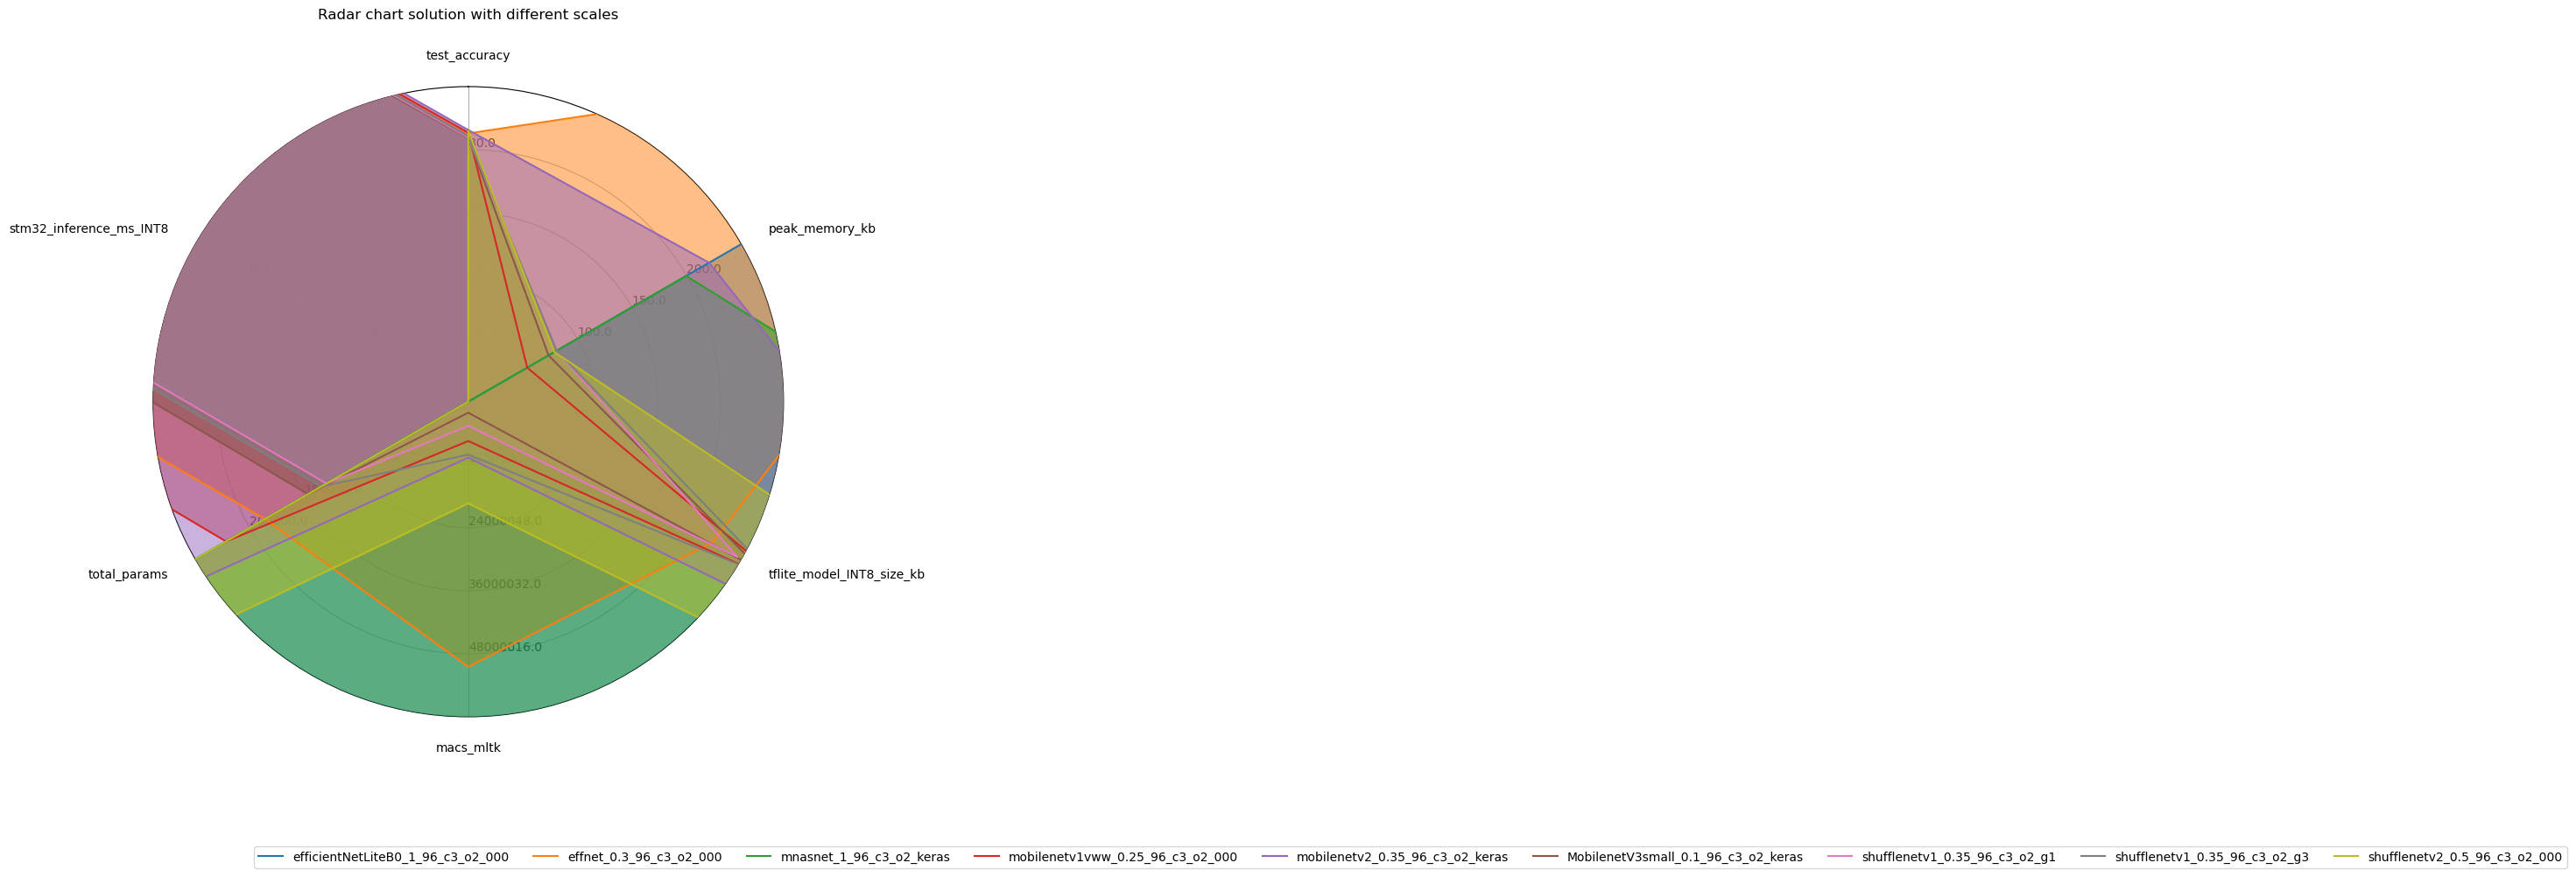

In [435]:


import math


# min_max_per_variable = basemodels_radar.describe().T[['min', 'max']]
# min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
# min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))

variables = basemodels_radar.columns
print(variables)
#ranges = list(min_max_per_variable.itertuples(index=False, name=None))   


####
# test_accuracy"] = basemodels_radar["test_accuracy"].copy()
# basemodels_radar_norm["peak_memory_norm"] = basemodels_radar["peak_memory_kb"]/250 * 100
# basemodels_radar_norm["model_size_norm"] = basemodels_radar["tflite_model_INT8_size_kb"]/250 * 100
# basemodels_radar_norm["total_params_norm"] = basemodels_radar["total_params"]/(1024 *2.5) 
# basemodels_radar_norm["inference_time_norm"] = basemodels_r
####
ranges = list([
    (0, 100), # test_accuracy
    (0, 250), # peak_memory
    (0, 250), # model_size
    (80, 60000000), # MACs
    (0, 250000), # total params
    (0, 1.0) # inference_time
]
)

fig1 = plt.figure(figsize=(8, 8))
#fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, show_scales=True)

for g in basemodels_radar.index:
    radar.plot(basemodels_radar.loc[g].values, label=g)
    radar.fill(basemodels_radar.loc[g].values, alpha=0.5)

radar.set_title("Radar chart solution with different scales")
radar.use_legend(loc='lower left', bbox_to_anchor=(0.15, -0.25),ncol=radar.plot_counter)
plt.show() 

# Leaderboard Analysis

In [436]:
df_top = df[df["fit"]==True].copy()
df_top

,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param,tag,fit
6,1scypuy0,mobilenettiny_0.7_96_c3_o2_l5ll32pl64b0.25.MV3,finished,21.972 M,https://wandb.ai/susbrock/model_DB/runs/1scypuy0,mobilenettiny_0.7_96_c3_o2_l5ll32pl64b0.25.MV3,45.511 M,0.7,2,96,45510755.0,3,21972369.0,l5ll32pl64b0.25.MV3,0.017908,170919,45510755.0,930.003906,152064.0,21972369.0,0.017908,165795,5124,638.847656,654180.0,0.0,241.718750,247520.0,635076.0,0.0,179396.0,NaN,NaN,[],2023-04-27T06:45:57,"[susbrock, model_DB, 1scypuy0]",None,87.869388,1343.210,NaN,148.500000,241.718750,175.191406,1.343210,1.448171,None,True
7,blf3zebj,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.MV3,finished,21.946 M,https://wandb.ai/susbrock/model_DB/runs/blf3zebj,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.MV3,45.456 M,0.7,2,96,45456258.0,3,21945871.0,l5ll16pl32b0.25.MV3,0.017908,167202,45456258.0,915.664062,152064.0,21945871.0,0.017908,162188,5014,625.398438,640408.0,0.0,236.570312,242248.0,634552.0,0.0,178880.0,NaN,NaN,[],2023-04-27T06:44:25,"[susbrock, model_DB, blf3zebj]",None,0.000000,1296.450,NaN,148.500000,236.570312,174.687500,1.296450,1.448834,None,True
9,14rmmw4v,mobilenetv2_0.1_96_c3_o2_t6l1280.GAP,finished,1.692 M,https://wandb.ai/susbrock/model_DB/runs/14rmmw4v,mobilenetv2_0.1_96_c3_o2_t6l1280.GAP,3.643 M,0.1,2,96,3778886.0,3,1692166.0,t6l1280.GAP,0.003322,77492,3778886.0,760.726562,46080.0,1692166.0,0.003322,71898,5594,294.914062,301992.0,0.0,175.250000,179456.0,217836.0,0.0,108540.0,NaN,NaN,[],2023-04-27T06:40:29,"[susbrock, model_DB, 14rmmw4v]",None,77.916628,375.845,NaN,45.000000,175.250000,105.996094,0.375845,2.315800,None,True
10,y3hi9enk,mobilenetv2_0.1_96_c3_o2_t6l1280.MV1,finished,1.692 M,https://wandb.ai/susbrock/model_DB/runs/y3hi9enk,mobilenetv2_0.1_96_c3_o2_t6l1280.MV1,3.656 M,0.1,2,96,3791684.0,3,1692166.0,t6l1280.MV1,0.003290,77494,3791684.0,758.851562,46080.0,1692166.0,0.003290,71900,5594,294.789062,301864.0,0.0,174.953125,179152.0,217736.0,0.0,80292.0,NaN,NaN,[],2023-04-27T06:37:48,"[susbrock, model_DB, y3hi9enk]",None,78.327101,365.591,NaN,45.000000,174.953125,78.410156,0.365591,2.311818,None,True
18,hlj37w0x,mobilenettiny.e_0.7_96_c3_o2_l5ll32pl64b0.25.MV1,finished,22.136 M,https://wandb.ai/susbrock/model_DB/runs/hlj37w0x,mobilenettiny.e_0.7_96_c3_o2_l5ll32pl64b0.25.MV1,45.855 M,0.7,2,96,45854580.0,3,22135832.0,l5ll32pl64b0.25.MV1,0.017867,170197,45854580.0,923.363281,152064.0,22135832.0,0.017867,165073,5124,635.785156,651044.0,0.0,240.000000,245760.0,634544.0,0.0,178868.0,NaN,NaN,[],2023-04-18T09:45:21,"[susbrock, model_DB, hlj37w0x]",None,87.942356,NaN,NaN,148.500000,240.000000,174.675781,NaN,1.443974,None,True
19,3tipcphx,mobilenettiny.e_0.7_96_c3_o2_l5ll32pl32b0.25.MV1,finished,22.041 M,https://wandb.ai/susbrock/model_DB/runs/3tipcphx,mobilenettiny.e_0.7_96_c3_o2_l5ll32pl32b0.25.MV1,45.660 M,0.7,2,96,45659748.0,3,22040792.0,l5ll32pl32b0.25.MV1,0.017859,167337,45659748.0,911.828125,152064.0,22040792.0,0.017859,162301,5036,625.468750,640480.0,0.0,236.390625,242064.0,634288.0,0.0,178608.0,NaN,NaN,[],2023-04-18T09:42:39,"[susbrock, model_DB, 3tipcphx]",None,87.986863,NaN,NaN,148.500000,236.390625,174.421875,NaN,1.446566,None,True
20,rh6g1xee,mobilenettiny.e_0.7_96_c3_o2_l5ll16pl32b0.25.MV1,finished,22.032 M,https://wandb.ai/susbrock/model_DB/runs/rh6g1xee,mobilenettiny.e_0.7_96_c3_o2_l5ll16pl32b0.25.MV1,45.641 M,0.7,2,9

In [437]:
leaderboard = df_top.nlargest(20,'test_accuracy').copy()
leaderboard.sort_values("architecture", axis=0, inplace=True, key=lambda col: col.str.lower())
# max_accuracy = leaderboard.test_accuracy.max()
# leaderboard["leader"] = leaderboard.test_accuracy = max_accuracy
leaderboard

,id,run_name,state,MACs,url,architecture,FLOPs,alpha,classes,img_res,OPS_mltk,channels,macs_mltk,variation,energy_mltk,total_params,OPS_INT8_mltk,model_size_kb,peak_memory_b,macs_INT8_mltk,energy_INT8_mltk,trainable_params,non_trainable_params,tflite_model_size_kb,flash_model_size_b_mltk,n_unsupported_layers_mltk,tflite_model_INT8_size_kb,flash_model_size_b__INT8_mltk,RAM_runtime_memory_size_b_mltk,n_unsupported_layers_INT8_mltk,RAM_runtime_memory_size_b_INT8_mltk,opt_RAM_mltk,opt_RAM_INT8_mltk,tags,created_at,path,notes,test_accuracy,inference_avg_us,stm32_inference_ms_INT8,peak_memory_kb,flash_model_size_kb_INT8_mltk,RAM_runtime_memory_size_kb_INT8_mltk,inference_GPU_ms,bytes_per_param,tag,fit
20,rh6g1xee,mobilenettiny.e_0.7_96_c3_o2_l5ll16pl32b0.25.MV1,finished,22.032 M,https://wandb.ai/susbrock/model_DB/runs/rh6g1xee,mobilenettiny.e_0.7_96_c3_o2_l5ll16pl32b0.25.MV1,45.641 M,0.7,2,96,45640685.0,3,22032058.0,l5ll16pl32b0.25.MV1,0.017860,167018,45640685.0,911.789062,152064.0,22032058.0,0.017860,162004,5014,624.500000,639488.0,0.0,235.812500,241472.0,634148.0,0.0,178480.0,NaN,NaN,[],2023-04-18T09:39:09,"[susbrock, model_DB, rh6g1xee]",None,88.105446,NaN,NaN,148.5,235.812500,174.296875,NaN,1.445784,None,True
66,q8qkl3hk,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.GAP,finished,21.946 M,https://wandb.ai/susbrock/model_DB/runs/q8qkl3hk,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.GAP,45.456 M,0.7,2,96,45455870.0,3,21945685.0,l5ll16pl32b0.25.GAP,0.017870,167018,45455870.0,913.929688,152064.0,21945685.0,0.017870,162004,5014,624.335938,639320.0,0.0,235.601562,241256.0,634236.0,0.0,178564.0,NaN,NaN,[],2023-04-07T06:36:50,"[susbrock, model_DB, q8qkl3hk]",None,88.133895,NaN,NaN,148.5,235.601562,174.378906,NaN,1.444491,None,True
57,eaoufey9,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.GAPLR,finished,21.946 M,https://wandb.ai/susbrock/model_DB/runs/eaoufey9,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.GAPLR,44.413 M,0.7,2,96,44412878.0,3,21945685.0,l5ll16pl32b0.25.GAPLR,0.017870,167018,44412878.0,912.445312,202752.0,21945685.0,0.017870,162004,5014,628.253906,643332.0,0.0,240.421875,246192.0,839128.0,0.0,231392.0,NaN,NaN,[],2023-04-08T09:46:55,"[susbrock, model_DB, eaoufey9]",None,88.734835,1451.460,NaN,198.0,240.421875,225.968750,1.451460,1.474045,None,True
65,ouxcytlr,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.MV1,finished,21.946 M,https://wandb.ai/susbrock/model_DB/runs/ouxcytlr,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.MV1,45.456 M,0.7,2,96,45455978.0,3,21945685.0,l5ll16pl32b0.25.MV1,0.017835,167018,45455978.0,911.789062,152064.0,21945685.0,0.017835,162004,5014,624.007812,638984.0,0.0,235.218750,240864.0,634148.0,0.0,178480.0,NaN,NaN,[],2023-04-07T06:38:29,"[susbrock, model_DB, ouxcytlr]",None,88.406456,NaN,NaN,148.5,235.218750,174.296875,NaN,1.442144,None,True
58,2wk28r6b,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.MV1LR,finished,21.946 M,https://wandb.ai/susbrock/model_DB/runs/2wk28r6b,mobilenettiny_0.7_96_c3_o2_l5ll16pl32b0.25.MV1LR,44.413 M,0.7,2,96,44412986.0,3,21945685.0,l5ll16pl32b0.25.MV1LR,0.017835,167018,44412986.0,910.304688,202752.0,21945685.0,0.017835,162004,5014,627.937500,643008.0,0.0,240.054688,245816.0,839040.0,0.0,231308.0,NaN,NaN,[],2023-04-08T09:43:53,"[susbrock, model_DB, 2wk28r6b]",None,88.515919,1389.930,NaN,198.0,240.054688,225.886719,1.389930,1.471793,None,True
56,kyj4dfpt,mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.GAPLR,finished,21.967 M,https://wandb.ai/susbrock/model_DB/runs/kyj4dfpt,mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.GAPLR,44.456 M,0.7,2,96,44456438.0,3,21967267.0,l5ll16pl64b0.25.GAPLR,0.017870,169636,44456438.0,922.902344,202752.0,21967267.0,0.017870,164534,5102,637.621094,652924.0,0.0,243.789062,249640.0,839512.0,0.0,231652.0,NaN,NaN,[],2023-04-08T09:49:03,"[susbrock, model_DB, kyj4dfpt]",None,88.561523,1285.380,NaN,198.0,243.789062,226.222656,1.285380,1.471622,None,True
48,dfppzg06,mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.GAP...,finished,21.967 M,https://wandb.ai/susbrock/model_DB/runs/dfppzg06,mobile

In [438]:
plot_model_parameters(leaderboard, title=" - leaderboard")


In [439]:
plot_model_size(leaderboard, title=" - leaderboard")

In [440]:
plot_model_MACs(leaderboard, title=" - leaderboard")

In [441]:
plot_model_RAM(leaderboard, title=" - leaderboard")

In [442]:
plot_model_peak_memory(leaderboard, title=" - leaderboard")

In [443]:
plot_model_accuracy(leaderboard, title=" - leaderboard")

In [444]:
plot_model_latency_cpu(leaderboard, title=" - leaderboard")

In [445]:
#leaderboard.architecture.to_list()

In [446]:
plot_model_latency_mcu(leaderboard, title=" - leaderboard")

# MobileNet Tiny

In [ ]:

mbn_tiny_df = get_model_family_df("mobilenettiny")
mbn_tiny_df.head()

In [ ]:
# MobileNet Tiny

In [ ]:
plot_model_parameters(mbn_tiny_df, title=" - MobilenNetTiny")

In [ ]:
plot_model_size(mbn_tiny_df, title=" - MobilenNetTiny")

In [ ]:
plot_model_MACs(mbn_tiny_df, title=" - MobilenNetTiny")

In [ ]:
plot_model_RAM(mbn_tiny_df, title=" - MobilenNetTiny")

In [ ]:
plot_model_peak_memory(mbn_tiny_df, title=" - MobilenNetTiny")

In [ ]:
plot_model_accuracy(mbn_tiny_df, title=" - MobilenNetTiny")

# MobileNetv V1 Analysis

In [ ]:
# mobilenetv1_list = df[["architecture"]].query("architecture.str.contains('mobilenetv1', na=False)").copy()
# mobilenetv1_list = mobilenetv1_list["architecture"].tolist()
# mobilenetv1_list

In [ ]:
mbnv1_df = get_model_family_df("mobilenetv1")
mbnv1_df.head()

In [ ]:
mbnv1_df.columns

In [ ]:
ax = mbnv1_df.hist(column=["bytes_per_param"],bins=20, figsize=(3, 4))

In [ ]:
mbnv1_df["MACs_kB"]=create_kb_column(mbnv1_df, "MACs")
mbnv1_df.head()

In [ ]:
mbnv1_96_df = mbnv1_df[["architecture"]].query("architecture.str.contains('_96_', na=False) & architecture.str.contains('_o2', na=False)").copy()
mbnv1_96_df.sort_values("architecture", axis=0, inplace=True)
mbnv1_96_df.head()

In [ ]:
mbnv1_size_df_long = create_size_df_long(mbnv1_df)
#mbnv1_size_df_long

In [ ]:
ax = mbnv1_df.hist(column=["bytes_per_param"],bins=20, figsize=(3, 4))

In [ ]:
mbnv1_size_df_long = create_size_df_long(mbnv1_df)
mbnv1_memory_fig = memory_fig(mbnv1_size_df_long)

In [ ]:
plot_accuracy_macs_by_model_family("mobilenetv1")

# MobileNet V2 Analysis

In [ ]:
mbnv2_df = get_model_family_df("mobilenetv2")
mbnv2_df.head()

In [ ]:
mbnv2_df.MACs.unique()

In [ ]:
ax = mbnv2_df.hist(column=["bytes_per_param"],bins=20, figsize=(3, 4))

In [ ]:
mbnv2_size_df_long = create_size_df_long(mbnv2_df)
mobilenetv2_mem_fig = memory_fig(mbnv2_size_df_long)

In [ ]:
for i in range(1,7):

    mbnv2_df.loc[mbnv2_df['run_name'].str.contains(f"t{i}", case=False), "t"] = i
mbnv2_df["t"].fillna(0, inplace=True)
mbnv2_df["t"] = mbnv2_df["t"].astype(int)
mbnv2_df.head()

In [ ]:
for layer in ["64", "128", "256", "512", "1024"]:
    mbnv2_df.loc[mbnv2_df['run_name'].str.contains(f"l{layer}", case=False), "last_layer_channels"] = int(layer)
mbnv2_df.head()

In [ ]:
for head in ["MV1", "GAP"]:
    mbnv2_df.loc[mbnv2_df['run_name'].str.contains(f".{head}", case=False), "head"] = head
mbnv2_df.head()

In [ ]:
mbnv2_df_split = mbnv2_df.architecture.str.rsplit('l', 1, expand=True).rename(lambda x: f'col{x + 1}', axis=1)
mbnv2_df_split.head()

In [ ]:
mbnv2_df_t4 = mbnv2_df.loc[mbnv2_df['t']==4]
mbnv2_df_t4

In [ ]:
### TODO: Clean up accuracy plots
macs_accuracy_fig = px.scatter(
    mbnv2_df,
    x = "macs_mltk",
    #x="MACs",
    y="test_accuracy",
    color="alpha",
    hover_data=["run_name","alpha", "macs_mltk", "total_params", "peak_memory_kb"],
    #size="tflite_model_INT8_size_kb",
    #labels={"total_params": "parameters", "OPS_INT8_mltk": "FLOPs"},
    title=f"Accuracy vs. MACs",
)
macs_accuracy_fig.update_layout(showlegend=True, width=1200, height=400)

macs_accuracy_fig.show()

In [ ]:

macs_accuracy_fig = px.scatter(
mbnv2_df_t4,
x = "macs_mltk",
#x="MACs",
#x="MACs_kb",
y="test_accuracy",
color="alpha",
hover_data=["run_name","alpha", "macs_mltk", "total_params", "peak_memory_kb"],
#size="tflite_model_INT8_size_kb",
#labels={"total_params": "parameters", "OPS_INT8_mltk": "FLOPs"},
title=f"Accuracy vs. MACs" # - {model_family}",
)

macs_accuracy_fig.show()

In [ ]:

# macs_params_fig = px.scatter(
#     mbnv2_df,
#     x="macs_mltk",
#     y="tflite_model_INT8_size_kb",
#     color="alpha",
#     size="total_params",
#     hover_data=["run_name","alpha", "macs_mltk", "total_params"],
#     labels={"macs_mltk": "MACs", 
#             "tflite_model_INT8_size_kb" : "INT8 model size in kB",
#             "total_params": "parameters"},
#     title=f"INT8 model size vs. MACs",
# )

# macs_params_fig.update_layout(showlegend=True, width=500, height=400)

# macs_params_fig.show()

In [ ]:
def params_macs_alpha_fig(df, model_name):
    df["alpha"] = df["alpha"].astype(str)
    fig = px.scatter(
        df,
        x="total_params",
        y="macs_mltk",
        color="alpha",
        hover_data=["run_name","alpha", "macs_mltk", "total_params"],
        size="tflite_model_INT8_size_kb",
        labels={"total_params": "parameters", 
                "macs_mltk": "MACs",
                "run_name": "model name"},
        title=f"MACs vs. total parameters - {model_name}",
    )
    fig.add_hline(y=60000000, line_width=2, line_dash="dash", line_color="red", annotation_text=f"60M MACs", 
               annotation_position="top")
    fig.update_layout(showlegend=True, width=1200, height=400)
    
    fig.show()
    return fig


In [ ]:
mbnv2_fig = params_macs_alpha_fig(mbnv2_df, "MobileNet V2")

In [ ]:
flops_params_fig = px.scatter(
    mbnv2_df,
    x="total_params",
    y="OPS_INT8_mltk",
    color="alpha",
    size="tflite_model_INT8_size_kb",
    hover_data=["run_name","alpha", "macs_mltk", "total_params"],
    labels={"total_params": "parameters", "OPS_INT8_mltk": "FLOPs"},
    title=f"FLOPs vs. total parameters",
)
flops_params_fig.update_layout(showlegend=True, width=500, height=400)

flops_params_fig.show()

In [ ]:
# df["peak_memory_kb"] = df["peak_memory_b"]/1024.0
# df["flash_model_size_kb_INT8_mltk"] = df["flash_model_size_b__INT8_mltk"]/1024.0
# df["RAM_runtime_memory_size_kb_INT8_mltk"] = df["RAM_runtime_memory_size_b_INT8_mltk"]/1024.0

# Plotting construction zone

In [ ]:
# size_fig = px.bar(mbnv2_df, x="alpha", y= ["peak_memory_kb",
#                                            "RAM_runtime_memory_size_kb_INT8_mltk",
#                                            "flash_model_size_kb_INT8_mltk",
#                                            "tflite_model_INT8_size_kb"], 
#                   text_auto=".2s",
#                   labels={"name" : "layer",
#                           "macs" : "MACs"},
#                      width=1200, height=600,
#     title=f"Model size")
# size_fig.add_hline(y=256, line_width=3, line_dash="dash", line_color="orange", annotation_text="256 kB MCU constraint", 
#             annotation_position="bottom right")
# #peak_memory = peak_memory_df["RAM_b"].max()
# #peak_mem_fig.add_hline(y=peak_memory, line_width=3, line_dash="dash", line_color="red", annotation_text=f"{peak_memory} B peak activation", 
# #               annotation_position="top")
# # tflite_fig.update_layout(yaxis_range=[0,300])
# size_fig.update_traces(width=1)
# size_fig.update_layout(showlegend=True)

# size_fig.show()

In [ ]:
# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])
# #fig = go.Figure()#specs=[[{"secondary_y": True}]])
# # Add traces
# fig.add_trace(go.Bar(x = mbnv2_df["alpha"],
#                                    y = mbnv2_df["tflite_model_INT8_size_kb"],#, mbnv2_df["peak_memory_b"]], 
#                                    name= "model size in kB"
#                                    ),
#                                    col=1,
#                                    row=1,
#                                    secondary_y=False)

# fig.add_trace(go.Bar(x = mbnv2_df["alpha"],
#                                    y = mbnv2_df["peak_memory_b"], 
#                                    name= "peak memory in B"
#                                    ),
#                                    col=1,
#                                    row=1,
#                                    secondary_y=True)



# # fig.add_trace(
# #     go.Scatter(x=[2, 3, 4], y=[4, 5, 6], name="yaxis2 data"),
# #     secondary_y=True,
# # )

# # Add figure title
# fig.update_layout(
#     title_text="Double Y Axis Example"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="xaxis title")

# # Set y-axes titles
# fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
# fig.update_layout(barmode="group",
#                   bargap=0.15, # gap between bars of adjacent location coordinates.
#                     bargroupgap=0.1 # gap between bars of the same location coordinate.)
# )
# fig.show()

wandb.log({"my_chart": wandb.Html(plotly.io.to_html(fig)})

# ShuffleNet V2 tiny Analysis

In [ ]:
shufflenetv2tiny_list = df[["architecture"]].query("architecture.str.contains('shufflenetv2tiny')").copy()


In [ ]:
shufflenetv2tiny_list = shufflenetv2tiny_list["architecture"].tolist()
shufflenetv2tiny_list

In [ ]:
shufflev2tiny_df = get_model_family_df("shufflenetv2tiny")
shufflev2tiny_df.head()

In [ ]:
#shufflev2tiny_df["last_layer_channels"]= 
shufflev2tiny_df_split = shufflev2tiny_df.architecture.str.rsplit('l', 1, expand=True).rename(lambda x: f'col{x + 1}', axis=1)
#shufflev2tiny_df_split

In [ ]:
shufflev2tiny_df_split2 = shufflev2tiny_df_split.col1.str.rsplit('_f', 1, expand=True).rename(lambda x: f'col{x + 1}', axis=1)
#shufflev2tiny_df_split2

In [ ]:
shufflev2tiny_df["first_layer_channels"] = shufflev2tiny_df_split2["col2"].map(int)
shufflev2tiny_df["last_layer_channels"] = shufflev2tiny_df_split["col2"].map(int)
shufflev2tiny_df["architecture_alpha"] = shufflev2tiny_df_split2["col1"]
#shufflev2tiny_df.reindex(columns="id")
shufflev2tiny_df.head()

In [ ]:
shufflev2tiny_df_01 =shufflev2tiny_df.loc[(shufflev2tiny_df['tflite_model_INT8_size_kb']<=256) & (shufflev2tiny_df['RAM_runtime_memory_size_kb_INT8_mltk']<= 256) & (shufflev2tiny_df['alpha'] == "0.1")]

In [ ]:
### TODO: Clean up accuracy plots
accuracy_fig = px.scatter(
    shufflev2tiny_df,
    x = "last_layer_channels",
    y="test_accuracy",
    color="architecture_alpha",
    symbol="first_layer_channels",
    symbol_sequence= ['circle-open', 'star', 'square'],
    hover_data=["run_name","alpha", "macs_mltk", "total_params", "peak_memory_kb"],
    #size="tflite_model_INT8_size_kb",
    #labels={"total_params": "parameters", "OPS_INT8_mltk": "FLOPs"},
    title=f"Accuracy vs. MACs - ShuffleNetV2Tiny",
)
accuracy_fig.update_layout(showlegend=True, width=1000, height=400)
accuracy_fig.update_layout(yaxis_range= [75, 90])
accuracy_fig.update_xaxes(showspikes=True)
accuracy_fig.update_yaxes(showspikes=True)

accuracy_fig.show()

In [ ]:
import plotly.express as px
#df = px.data.iris()
fig = px.scatter_3d(shufflev2tiny_df, x='first_layer_channels', y='last_layer_channels', z='test_accuracy',
              color='alpha')
fig.show()

 x="total_params",
    y="OPS_INT8_mltk",
    color="alpha",
    size="tflite_model_INT8_size_kb",

In [ ]:
first_layer_channels = True
last_layer_channels = True

plot_df = shufflev2tiny_df

In [ ]:
dimensions = list([
                    dict(#range = [0,8],
                        tickvals =["0", "0.05", "0.1", "0.2", "0.25", "0.35", "0.5", "0.7"],
                        label = 'Alpha', values = plot_df['alpha'])])

if first_layer_channels:                    
    dimensions.append(dict(#range = [0,8],
        #constraintrange = [8],
        tickvals =[8, 16, 24],
        label = 'First Layer Channels', values = plot_df['first_layer_channels']))

if last_layer_channels:
    dimensions.append(
                    dict(#range = [0,8],
                        tickvals =[0, 8, 16, 64, 128, 256, 512, 1024],
                        label = 'Last Layer Channels', values = plot_df['last_layer_channels']),
                    # dict(range = [0,8],
                    #     label = 'Petal Length', values = shufflev2tiny_df['petal_length']),

                    )
dimensions.append(                    dict(range = [79,86],
                        label = 'Test Accuracy %', values = plot_df['test_accuracy'])
                )

fig = go.Figure(data=
    go.Parcoords(
        #line = dict(color = shufflev2tiny_df['test_accuracy'],
                   #colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']]),
        #),
        dimensions = dimensions,
        line = dict(color = plot_df['test_accuracy'],
                   colorscale = 'Bluered', # 'Jet'   # https://plotly.com/python/builtin-colorscales/
                   showscale = True,
                   #dashed = True,
                   #reversescale=True,
                   cmin = 79,
                   cmax = 89),


    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [ ]:
plot_df.set_index("id", inplace=True)
plot_df.head()

In [ ]:
indices = plot_df.index.to_list()
for id in indices:
    model_stats = {}
    model_stats["last_layer_channels"] = plot_df.loc[id, "last_layer_channels"]
    model_stats["first_layer_channels"] = plot_df.loc[id, "first_layer_channels"]
    #model_stats["head"] = plot_df.loc[id, "head"]
    print(model_stats["first_layer_channels"])
    print(model_stats["last_layer_channels"])
    #print(model_stats["head"])
    #print(plot_df.loc[id, "last_layer_channels"])
    #print(id)

In [ ]:
fig = go.Figure(data=
    go.Parcoords(
        #line = dict(color = shufflev2tiny_df['test_accuracy'],
                   #colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']]),
        #),
        line = dict(color = shufflev2tiny_df['test_accuracy'],
                   colorscale = 'Bluered', # 'Jet'   # https://plotly.com/python/builtin-colorscales/
                   showscale = True,
                   #dashed = True,
                   #reversescale=True,
                   cmin = 79,
                   cmax = 89),
        dimensions = list([
                    dict(range = [0,1],
                        tickvals =["0", "0.05", "0.1", "0.2", "0.25", "0.35", "0.5", "0.7", "1"],
                        label = 'Alpha', values = shufflev2tiny_df['alpha']),
                    dict(#range = [0,8],
                        #constraintrange = [8],
                        tickvals =[8, 16, 24],
                        label = 'First Layer Channels', values = shufflev2tiny_df['first_layer_channels']),

                    dict(#range = [0,8],
                        tickvals =[0, 8, 16, 64, 128, 256, 512, 1024],
                        label = 'Last Layer Channels', values = shufflev2tiny_df['last_layer_channels']),
                    # dict(range = [0,8],
                    #     label = 'Petal Length', values = shufflev2tiny_df['petal_length']),
                    dict(range = [79,86],
                        label = 'Test Accuracy %', values = shufflev2tiny_df['test_accuracy'])
                ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [ ]:
ax = shufflev2tiny_df.hist(column=["bytes_per_param"],bins=20, figsize=(3, 4))

In [ ]:
shufflev2tiny_df_long = create_size_df_long(shufflev2tiny_df)
shufflev2tiny_mem_fig = memory_fig(shufflev2tiny_df_long)

In [ ]:
#plot_accuracy_macs_by_model_family("shufflenetv2tiny")

In [ ]:
### TODO: Clean up accuracy plots
macs_accuracy_fig = px.scatter(
    shufflev2tiny_df,
    x = "macs_mltk",
    y="test_accuracy",
    color="alpha",
    hover_data=["run_name","alpha", "macs_mltk", "total_params", "peak_memory_kb"],
    #size="tflite_model_INT8_size_kb",
    #labels={"total_params": "parameters", "OPS_INT8_mltk": "FLOPs"},
    title=f"Accuracy vs. MACs - ShuffleNetV2Tiny",
)
macs_accuracy_fig.update_layout(showlegend=True, width=1200, height=400)

macs_accuracy_fig.show()

# Analysis of single architectures

In [ ]:
architecture = "mobilenetv1_0.1_96_c3_o2_l2.MV1"

In [ ]:
run_id =  get_model_DB_run_id_from_architecture(architecture)
run_id

In [ ]:
# get model name from run_id
model_name = df.query(f"id=='{run_id}'")['architecture'].values[0]
model_name

In [ ]:
def plot_macs_per_layer(architecture):
    #architecture_1 = "mobilenetv2_0.25_96_c3_o2_l5"
    run_id = get_model_DB_run_id_from_architecture(architecture)
    df = get_wandb_table_as_df(run_id, "tflite_layers_mltk")
    macs_fig = px.bar(df, x="name", y= "macs",
                  text_auto=".2s",
                  labels={"name" : "layer",
                          "macs" : "MACs"},
                     width=1200, height=600,
                     template=template,
    title=f"MACs per layer - tflite {architecture}")
    macs_fig.update_traces(width=1)
    macs_fig.update_layout(showlegend=False)

    #macs_fig.show()
    return macs_fig


In [ ]:
def input_height_per_layer(architecture):
    run_id = get_model_DB_run_id_from_architecture(architecture)
    df = get_wandb_table_as_df(run_id, "tensorflow_layer_details")
    macs_fig = px.bar(df, x="layer_name", y= "h_i_1",
                  text_auto=".2s",
                  labels={"name" : "layer",
                          "h_i_1" : "input height"},
                     width=1200, height=600,
                     template=template,
    title=f"Input height per layer - TensorFlow {architecture}")
    macs_fig.update_traces(width=1)
    macs_fig.update_layout(showlegend=False)

    #macs_fig.show()
    return macs_fig

In [ ]:
def params_per_layer(architecture):
    run_id = get_model_DB_run_id_from_architecture(architecture)
    df = get_wandb_table_as_df(run_id, "tensorflow_layer_details")
    fig = px.bar(df, x="layer_name", y= "params",
                  text_auto=".2s",
                  labels={"layer_name" : "Layer Name",
                          "params" : "Parameters"},
                     width=1200, height=600,
                     template=template,
    title=f"Parameters per Layer - TensorFlow {architecture}")
    fig.update_traces(width=1)
    fig.update_layout(showlegend=False)

    #macs_fig.show()
    return fig

In [ ]:
architecture = "shufflenetv2_0.5_96_c3_o2_000"

In [ ]:
run_id = get_model_DB_run_id_from_architecture(architecture)
shufflenetv2_layers = get_wandb_table_as_df(run_id, "tensorflow_layer_details")

In [ ]:
shufflenetv2_layers.nlargest(10, "params")

In [ ]:
params_per_layer("shufflenetv2_0.5_96_c3_o2_000")

# Comparison of two models

In [ ]:
architecture_1 = "mobilenettiny_0.7_96_c3_o2_l5ll32pl32b0.25.MV1NBN"
run_id_1 = get_model_DB_run_id_from_architecture(architecture_1)
architecture_2 = "mobilenettiny_0.7_96_c3_o2_l5ll32pl32b0.25.MV1NBNHS"
run_id_2 = get_model_DB_run_id_from_architecture(architecture_2)

In [ ]:
run_id_2

In [ ]:
ENTITY = "susbrock"
PROJECT ="model_DB"
#run_id = "27bt3quc"
table_name = "tflite_layers_mltk"

In [ ]:
df_1 = get_wandb_table_as_df(run_id_1, table_name)
df_1.head()

In [ ]:
df_2 = get_wandb_table_as_df(run_id_2, table_name)
df_2.head()

In [ ]:
input_height_per_layer(architecture_1)

In [ ]:
plot_macs_per_layer(architecture_1)

In [ ]:
def plot_macs_per_layer_comparison(architecture_1, architecture_2):
    run_id_1 = get_model_DB_run_id_from_architecture(architecture_1)
    run_id_2 = get_model_DB_run_id_from_architecture(architecture_2)
    df_1 = get_wandb_table_as_df(run_id_1, "tflite_layers_mltk")
    df_2 = get_wandb_table_as_df(run_id_2, "tflite_layers_mltk")

    # dict for the dataframes and their names
    dfs = {architecture_1 : df_1, architecture_2 : df_2}

    fig = go.Figure(layout_title_text=f"MACs per layer overlay - {architecture_1} vs {architecture_2}")

    for i in dfs:
        fig = fig.add_trace(go.Bar(x = dfs[i]["index"],
                                    y = dfs[i]["macs"], 
                                    name = i))
    return fig

In [ ]:
plot_macs_per_layer_comparison(architecture_1, architecture_2)

# Get Twin Models - No Batchnorm

In [ ]:
#NBN = df[df["architecture"]].value_counts()
NBN = df[["architecture"]].query("architecture.str.contains('NBN', na=False)").value_counts()
NBN

In [ ]:
NBN_df = df.query("architecture.str.contains('NBN', na=False)").copy()
NBN_df["architecture_full"] = NBN_df["architecture"]
NBN_df["architecture"] = NBN_df["architecture"].str.replace("NBN", "")
NBN_df["batch_norm"] = False
NBN_df.head()
NBN_df.head()


In [ ]:
NBN_list = NBN_df[["architecture"]]#.to_list()
NBN_list = NBN_list["architecture"].to_list()
NBN_list

In [ ]:
remove_architectures = ['mobilenetv1_0.35_96_c3_o2_l5ll128pl256b0.25.MV1',
                        'mobilenetv1_0.25_96_c3_o2_l5ll1024pl512.MV1']

for architecture in remove_architectures:
    NBN_list.remove(architecture)

In [ ]:
NB_list = []
for item in NBN_list:
    NB_list.append(item.replace("NBN", ""))
NB_list

In [ ]:
BN_df = df[df['architecture'].isin(NB_list)].copy()
BN_df["batch_norm"] = True
BN_df.head()
len(BN_df)

In [ ]:
batchnorm_df = pd.concat([NBN_df, BN_df])
batchnorm_df.sort_values(by="architecture", ascending=True, inplace=True)
batchnorm_df.head()

In [ ]:
def plot_model_accuracy_BN(df, title=""):
    accuracy_limit = 80

    fig = px.scatter(df, 
                x="architecture", 
                color="architecture",
                y='test_accuracy',
                symbol="batch_norm",
                symbol_sequence= ['circle-open', 'star'],
                #symbol_sequence= ['circle-open', 'circle', 'circle-open-dot', 'square'],
                labels={"architecture": "model architecture",
                        "test_accuracy": "test accuracy %",
                            #"value": "kB"
                            },
                title=f"Effect of BatchNorm layer after depthwise convolutions {title}",
                #text_auto=".5s",
                #barmode='group',
                #hover_data=['architecture', 'size'],
                height=height,
                template=template
                )
    #fig.add_hline(y=peak_memory_limit, line_width=2, line_dash="dash", line_color="orange", annotation_text=f"{peak_memory_limit} KB peak activation", 
    #            annotation_position="top left")
    fig.add_hline(y=accuracy_limit, line_width=2, line_dash="dash", line_color="blue", annotation_text=f"{accuracy_limit} accuracy %", 
                annotation_position="top right")
    #fig.update_traces(width=bar_width)
    #fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig.update_layout(yaxis_range= [84, 90])
    #fig.show()
    return fig

In [ ]:
plot_model_accuracy_BN(batchnorm_df[batchnorm_df["test_accuracy"] >=0])

# ShuffleNet V1

In [ ]:
# for shufflenet v1 
def extract_groups_from_name(architecture_name):

    groups = int(architecture_name.split("_")[-1].replace("g", ""))
    return groups

In [ ]:
shufflenetv1_df = get_model_family_df("shufflenetv1")

In [ ]:
shufflenetv1_df["groups"] = shufflenetv1_df["architecture"].apply(extract_groups_from_name)
shufflenetv1_df

In [ ]:
def params_macs_alpha_groups_fig(df,model_name):
    df["alpha"] = df["alpha"].astype(str)
    df["groups"] = df["groups"].astype(str)
    fig = px.scatter(
        df,
        x="total_params",
        y="macs_mltk",
        color="groups",
        hover_data=["alpha","groups", "macs_mltk", "total_params"],
        symbol= df["alpha"],
        #size="tflite_model_INT8_size_kb",
        labels={"total_params": "parameters", "macs_mltk": "MACs"},
        title=f"MACs vs. total parameters - {model_name}",
    )
    fig.add_hline(y=60000000, line_width=3, line_dash="dash", line_color="red", annotation_text=f"60M MACs", 
               annotation_position="top")
    fig.update_layout(showlegend=True, width=500, height=400)
    
    fig.show()
    return fig

In [ ]:
shufflev1_fig2 = params_macs_alpha_groups_fig(shufflenetv1_df, "ShuffleNet V1")

In [ ]:
shufflev1_size_df = shufflenetv1_df[["architecture", 
             "peak_memory_kb", 
             "RAM_runtime_memory_size_kb_INT8_mltk",
             "flash_model_size_kb_INT8_mltk",
             "tflite_model_INT8_size_kb"
             ]].copy()

In [ ]:
# fig = make_subplots(rows=2, cols=1, start_cell="bottom-left", column_widths=[1400],row_heights=[0.5, 0.5], vertical_spacing=0.3,
#                     subplot_titles=[architecture_1, architecture_2])
# fig = fig.add_trace(go.Bar(x = df_me["name"],
#                                    y = df_me["macs"], 
#                                    name = architecture_1,
                                   
#                                    text=df_me["macs"],
#                                    textposition='auto'),
#                                    row=1, col=1)
# fig = fig.add_trace(go.Bar(x = df_keras["name"],
#                                    y = df_keras["macs"], 
#                                    name = architecture_2),
#                                    row=2, col=1)

# fig.update_layout(
#     height = 1000,
#     width = 1200,
#     title="MACs per layer - tflite",
#     xaxis_title="layer name",
#     yaxis_title="MACs",
#     legend_title="architecture",
#     # font=dict(
#     #     family="Courier New, monospace",
#     #     size=18,
#     #     color="RebeccaPurple"
#     # )
#     legend=dict(
#     x=0,
#     y=1.0
#     )
# )


# fig.update_layout(showlegend=False)
# fig.show()

In [ ]:
ENTITY = "susbrock"
PROJECT = "model_DB"
run_id_3 = "fbfsftzr"
table_name ="Runorder"

api = wandb.Api()
artifact = api.artifact(f'{ENTITY}/{PROJECT}/run-{run_id}-{table_name}:latest')
artifact_dir = artifact.download()

In [ ]:
def get_wandb_node_type_summary_df(run_id):
    table_name = "Nodetypesummary"
    api = wandb.Api()
    artifact = api.artifact(f'{ENTITY}/{PROJECT}/run-{run_id}-{table_name}:latest')
    artifact_dir = artifact.download()
    table_path = Path(artifact_dir).joinpath("Node type summary.table.json")
    #print(f"filepath {table_path}")

    with open(table_path) as file:
        json_dict = json.load(file)
        #print(json_dict)
    df = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])

    return df

In [ ]:
node_type_summary_df = get_wandb_node_type_summary_df(run_id)
node_type_summary_df

In [ ]:
peak_memory_df = get_wandb_table_as_df(run_id_3, "peak_memory")
peak_memory_df.head()

In [ ]:
RAM_df = peak_memory_df[["index", "name", "RAM_b"]]
RAM_df.head()

In [ ]:
tensor_df = get_wandb_table_as_df(run_id_3, "tensor_info")
tensor_df.drop(0, axis=0, inplace=True)
tensor_df.reset_index(inplace=True)
tensor_df.head()

In [ ]:
size_df = tensor_df[["index", "name", "size_b"]]
size_df.head()

In [ ]:
INT8_layers_df = get_wandb_table_as_df(run_id_3, "tflite_INt8_layers_mltk")
INT8_layers_df.head()

In [ ]:
macs_df = INT8_layers_df[["index", "name", "ops", "macs"]]
macs_df.head()

In [ ]:
def get_wandb_run_order_df(run_id):
    table_name = "Runorder"
    api = wandb.Api()
    artifact = api.artifact(f'{ENTITY}/{PROJECT}/run-{run_id}-{table_name}:latest')
    artifact_dir = artifact.download()
    table_path = Path(artifact_dir).joinpath("Run order.table.json")
    #print(f"filepath {table_path}")

    with open(table_path) as file:
        json_dict = json.load(file)
        #print(json_dict)
    df = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])

    return df

In [ ]:
run_order_df = get_wandb_run_order_df(run_id_3)
run_order_df.reset_index(inplace=True)
run_order_df.head()

In [ ]:
time_df = run_order_df[["index", "node type", "first", "avg ms", "%"]]
time_df.head()

In [ ]:
combined_df = time_df.join(macs_df, on="index", rsuffix="_time")
combined_df = combined_df.join(RAM_df, on="index", rsuffix="_RAM" )
combined_df = combined_df.join(size_df, on="index", rsuffix="_size")
combined_df.head()

In [ ]:
combined_df["time_%"] = (combined_df['avg ms'] / combined_df['avg ms'].sum()) * 100
combined_df["RAM_%"] = (combined_df['RAM_b'] / combined_df['RAM_b'].sum()) * 100
combined_df["size_%"] = (combined_df['size_b'] / combined_df['size_b'].sum()) * 100
combined_df["ops_%"] = (combined_df['ops'] / combined_df['ops'].sum()) * 100
combined_df.head()

In [ ]:
# ### TODO: add parameters per layer
# ### TODO: create a function for this fig

# # trace1 = go.Bar(
# #     x=batchnorm_df["name"],
# #     y=batchnorm_df["time_%"],
# #     name="time %",
# #     marker=dict(
# #         color='grey'
# #                )
# # )
# trace2 = go.Scatter(
#     x=batchnorm_df["architecture"],
#     y=batchnorm_df['RAM_%'],
#     name='RAM %',
#     #yaxis='y2',
#     marker_symbol='star',
#     marker_color="black",
#     mode="markers+text",
#     #text = "Columns and elements to be displayed"

# )

# trace3 = go.Scatter(
#     x=batchnorm_df["architecture"],
#     y=batchnorm_df['ops_%'],
#     name='ops %',
#     #yaxis='y2',
#     marker_symbol='circle',
#     marker_color="blue",
#     mode="markers+text",
#     #text = "Columns and elements to be displayed"

# )

# trace4 = go.Scatter(
#     x=batchnorm_df["architecture"],
#     y=batchnorm_df['size_%'],
#     name='size %',
#     #yaxis='y2',
#     marker_symbol='cross', 
#     marker_color="orange",
#     mode="markers+text",
#     #text = "Columns and elements to be displayed"

# )

# fig= make_subplots()
# #fig = make_subplots(specs=[[{"secondary_y": True}]])
# #fig.add_trace(trace1)
# #fig.add_trace(trace2,secondary_y=True)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
# fig['layout'].update(height = 600, width = 1200, title ="Percentage per layer based on complete model - shufflenetv2tiny_0.5_96_c3_o2_f24l1024",xaxis=dict(
#       tickangle=-90
#     ))
# fig.show()

In [ ]:
### TODO: add parameters per layer
### TODO: create a function for this fig

trace1 = go.Bar(
    x=combined_df["name"],
    y=combined_df["time_%"],
    name="time %",
    marker=dict(
        color='grey'
               )
)
trace2 = go.Scatter(
    x=combined_df["name"],
    y=combined_df['RAM_%'],
    name='RAM %',
    #yaxis='y2',
    marker_symbol='star',
    marker_color="black",
    mode="markers+text",
    #text = "Columns and elements to be displayed"

)

trace3 = go.Scatter(
    x=combined_df["name"],
    y=combined_df['ops_%'],
    name='ops %',
    #yaxis='y2',
    marker_symbol='circle',
    marker_color="blue",
    mode="markers+text",
    #text = "Columns and elements to be displayed"

)

trace4 = go.Scatter(
    x=combined_df["name"],
    y=combined_df['size_%'],
    name='size %',
    #yaxis='y2',
    marker_symbol='cross', 
    marker_color="orange",
    mode="markers+text",
    #text = "Columns and elements to be displayed"

)

fig= make_subplots()
#fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
#fig.add_trace(trace2,secondary_y=True)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.add_trace(trace4)
fig['layout'].update(height = 600, width = 1200, title ="Percentage per layer based on complete model - shufflenetv2tiny_0.5_96_c3_o2_f24l1024",xaxis=dict(
      tickangle=-90
    ))
fig.show()

In [ ]:
fig = px.bar(combined_df, x=combined_df['index'], y=combined_df['avg ms'])
fig.add_scatter(x=combined_df["index"], y=combined_df["RAM_b"])
fig.show()

In [ ]:
trace1 = go.Bar(
    x=combined_df["index"],
    y=combined_df["avg ms"],
    name="avg ms",
    marker=dict(
        color='rgb(34,163,192)'
               )
)
trace2 = go.Scatter(
    x=combined_df["index"],
    y=combined_df['RAM_b'],
    name='RAM',
    yaxis='y2',
    marker_symbol='circle',
    mode="markers+text",
    #text = "Columns and elements to be displayed"

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 1200, title ="Test",xaxis=dict(
      tickangle=-90
    ))
fig.show()

In [ ]:

# dict for the dataframes and their names
dfs = {architecture_1 : run_order_df}


fig = go.Figure(layout_title_text="average runtime in micro seconds per layer")
#fig = make_subplots(rows=2, cols=1, start_cell="bottom-left")

for i in dfs:
    fig = fig.add_trace(go.Bar(x = dfs[i]["index"],
                                   y = dfs[i]["avg ms"], 
                                   name = i,
                                   hoverinfo="all"
                                   #hoverinfo=dfs[i]["Name"]
                                   )
                                   )
            
fig.show()